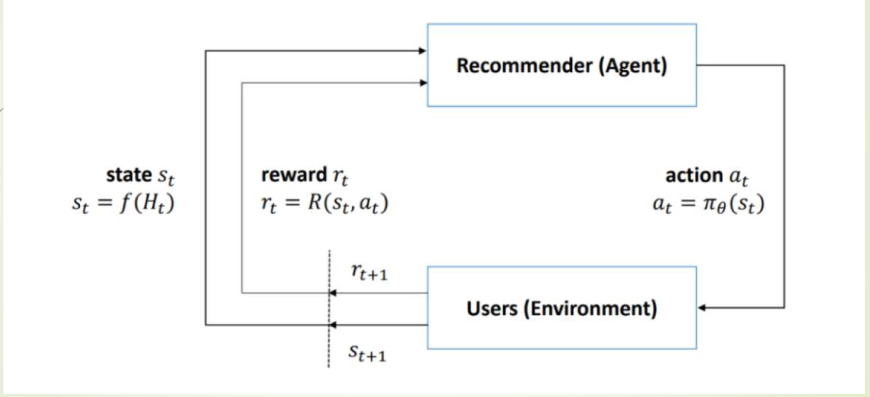

In [1]:
from pickle import load
from pickle import dump
import numpy as np
import pandas as pd
from dateutil.parser import parse
import os
from collections import Counter
import operator
from random import sample
import seaborn as sns
import matplotlib.pyplot as plt

https://archive.ics.uci.edu/ml/machine-learning-databases/00352/

In [2]:
# Change the filename to point to your location
filename = "data/Online Retail.xlsx"
# Let us load the customer Details
custDetails = pd.read_excel(filename, engine='openpyxl')
custDetails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
custDetails.shape

(541909, 8)

In [4]:
#Parsing  the date
custDetails['Parse_date'] = custDetails["InvoiceDate"].apply(lambda x: parse(str(x)))
# Parsing the weekdaty
custDetails['Weekday'] = custDetails['Parse_date'].apply(lambda x: x.weekday())
# Parsing the Day
custDetails['Day'] = custDetails['Parse_date'].apply(lambda x: x.strftime("%A"))
# Parsing the Month
custDetails['Month'] = custDetails['Parse_date'].apply(lambda x: x.strftime("%B"))
# Getting the year
custDetails['Year'] = custDetails['Parse_date'].apply(lambda x: x.strftime("%Y"))
# Getting year and month together as one feature
custDetails['year_month'] = custDetails['Year'] + "_" +custDetails['Month']
# Feature engineering of the customer details data frame
# Get the date  as a seperate column
custDetails['Date'] = custDetails['Parse_date'].apply(lambda x: x.strftime("%d"))
# Converting date to float for easy comparison
custDetails['Date']  = custDetails['Date'] .astype('float64')
# Get the period of month column
custDetails['monthPeriod'] = custDetails['Date'].apply(lambda x: int(x > 15))

custDetails.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Parse_date,Weekday,Day,Month,Year,year_month,Date,monthPeriod
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December,1.0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December,1.0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December,1.0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December,1.0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December,1.0,0


In [5]:
custDetails.shape

(541909, 16)

In [6]:
# Creating gross value column
custDetails['grossValue'] = custDetails["Quantity"] * custDetails["UnitPrice"]
# Consolidating accross the invoice number for gross value
retailConsol = custDetails.groupby('InvoiceNo')['grossValue'].sum().reset_index()
print(retailConsol.shape)
retailConsol.head()

(25900, 2)


,InvoiceNo,grossValue
0,536365,139.12
1,536366,22.20
2,536367,278.73
3,536368,70.05
4,536369,17.85


Now that we have got the data consolidated based on each invoice number, let us merge the data related features with the consolidated data. We merge the consolidated data with the custDetails data frame and then drop all the duplicate data so that we get a record per invoice number, along with its date features.

In [7]:
# Merge the other information like date, week, month etc
retail = pd.merge(retailConsol,custDetails[["InvoiceNo",'Parse_date','Weekday','Day','Month','Year','year_month','monthPeriod']],how='left',on='InvoiceNo')
# dropping ALL duplicate values
retail.drop_duplicates(subset ="InvoiceNo",keep = 'first', inplace = True)
print(retail.shape)
retail.head()

(25900, 9)


,InvoiceNo,grossValue,Parse_date,Weekday,Day,Month,Year,year_month,monthPeriod
0,536365,139.12,2010-12-01 08:26:00,2,Wednesday,December,2010,2010_December,0
7,536366,22.20,2010-12-01 08:28:00,2,Wednesday,December,2010,2010_December,0
9,536367,278.73,2010-12-01 08:34:00,2,Wednesday,December,2010,2010_December,0
21,536368,70.05,2010-12-01 08:34:00,2,Wednesday,December,2010,2010_December,0
25,536369,17.85,2010-12-01 08:35:00,2,Wednesday,December,2010,2010_December,0


Let us first look at the month wise consolidation of data and then plot the data. We will use a functions to map the months to its index position. THis is required to sort the data according to months. The function 'monthMapping', maps an integer value to the month and then sorts the data frame

In [8]:
# Create a map for each month
def monthMapping(mnthTrend):
    # Get the map
    mnthMap = {"January": 1, "February": 2,"March": 3, "April": 4,"May": 5, "June": 6,"July": 7, "August": 8,"September": 9, "October": 10,"November": 11, "December": 12}
    # Create a new feature for month
    mnthTrend['mnth'] = mnthTrend.Month
    # Replace with the numerical value
    mnthTrend['mnth'] = mnthTrend['mnth'].map(mnthMap)
    # Sort the data frame according to the month value
    return mnthTrend.sort_values(by = 'mnth').reset_index()

We aggragate the data as per months and then plot the month wise grossvalue 

No handles with labels found to put in legend.


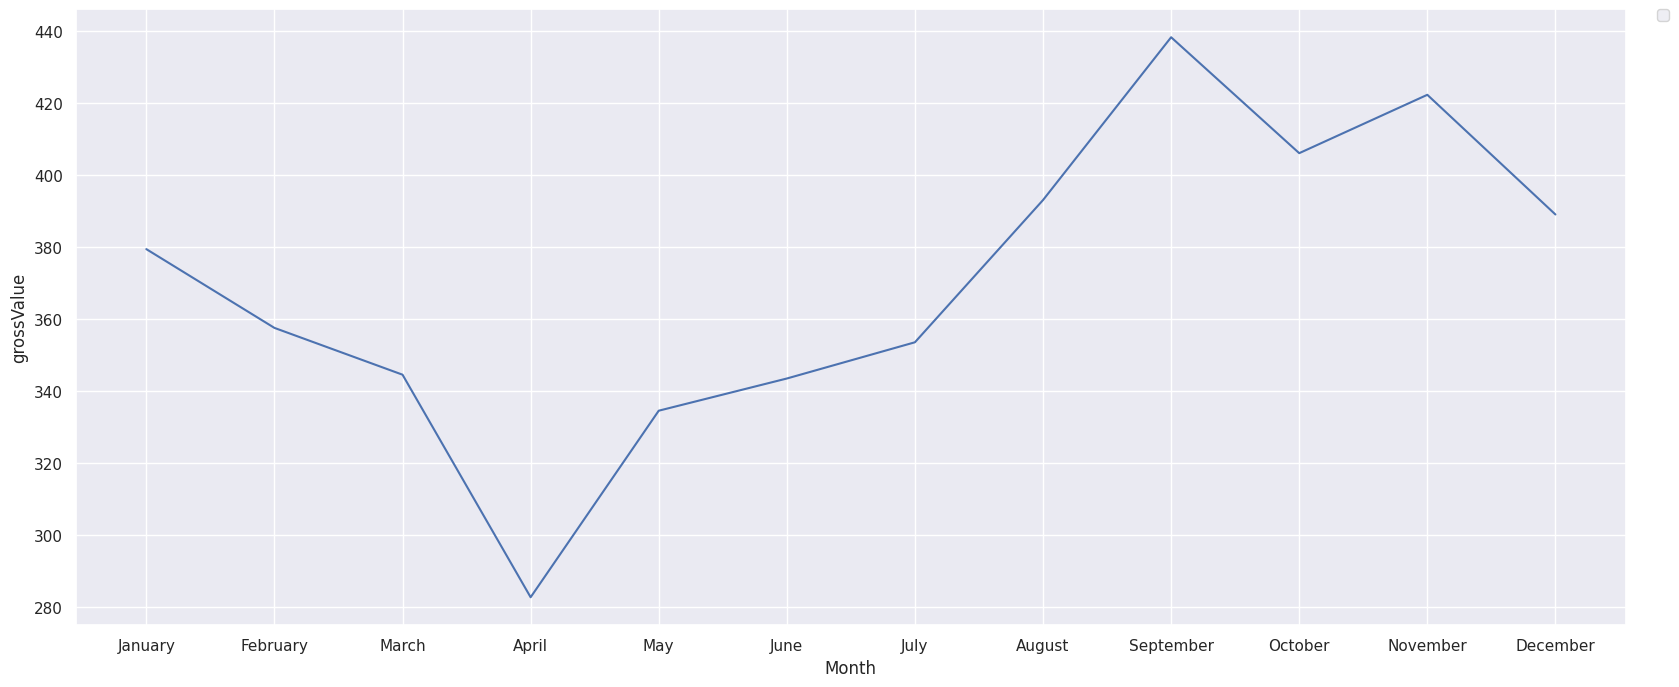

In [9]:
mnthTrend = retail.groupby(['Month'])['grossValue'].agg('mean').reset_index().sort_values(by = 'grossValue',ascending = False)
# sort the months in the right order
mnthTrend = monthMapping(mnthTrend)
sns.set(rc = {'figure.figsize':(20,8)})
sns.lineplot(data=mnthTrend, x='Month', y='grossValue')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

We can see that there is sufficient amount of variability of data month on month. So therefore we will take months as one of the context items on which the states can be constructed.

Let us now look at buying pattern within each month and check how the buying pattern is within the first 15 days and the latter half

No handles with labels found to put in legend.


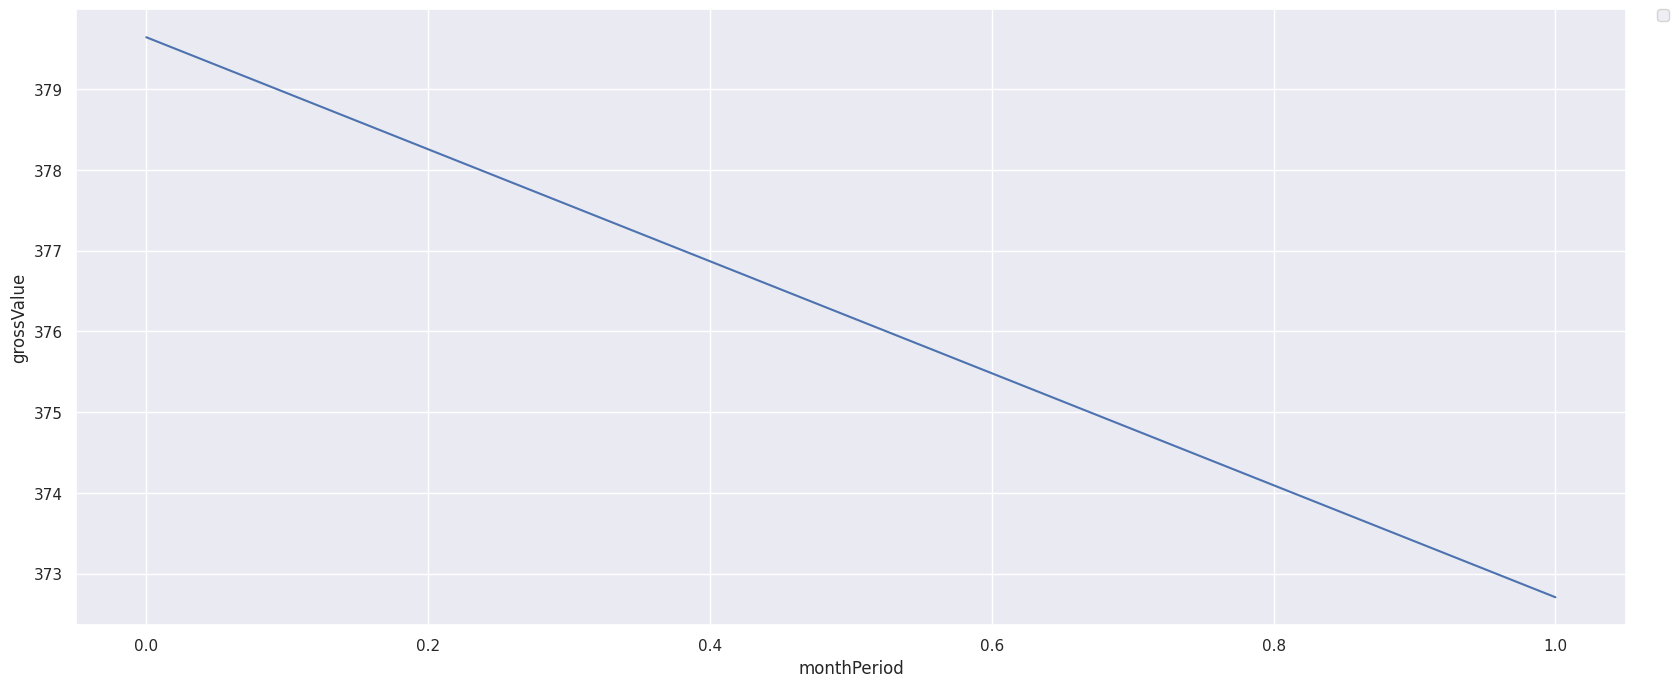

In [10]:
# Aggregating data for the first 15 days and latter 15 days
fortnighTrend = retail.groupby(['monthPeriod'])['grossValue'].agg('mean').reset_index().sort_values(by = 'grossValue',ascending = False)

sns.set(rc = {'figure.figsize':(20,8)})
sns.lineplot(data=fortnighTrend, x='monthPeriod', y='grossValue')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

We can see that there is as small difference between buying patterns in the first 15 days of the month and the latter half of the month. Eventhough the difference is not significant, we will still take this difference as another context.

Next let us aggregate data as per the days of the week and and check the trend

No handles with labels found to put in legend.


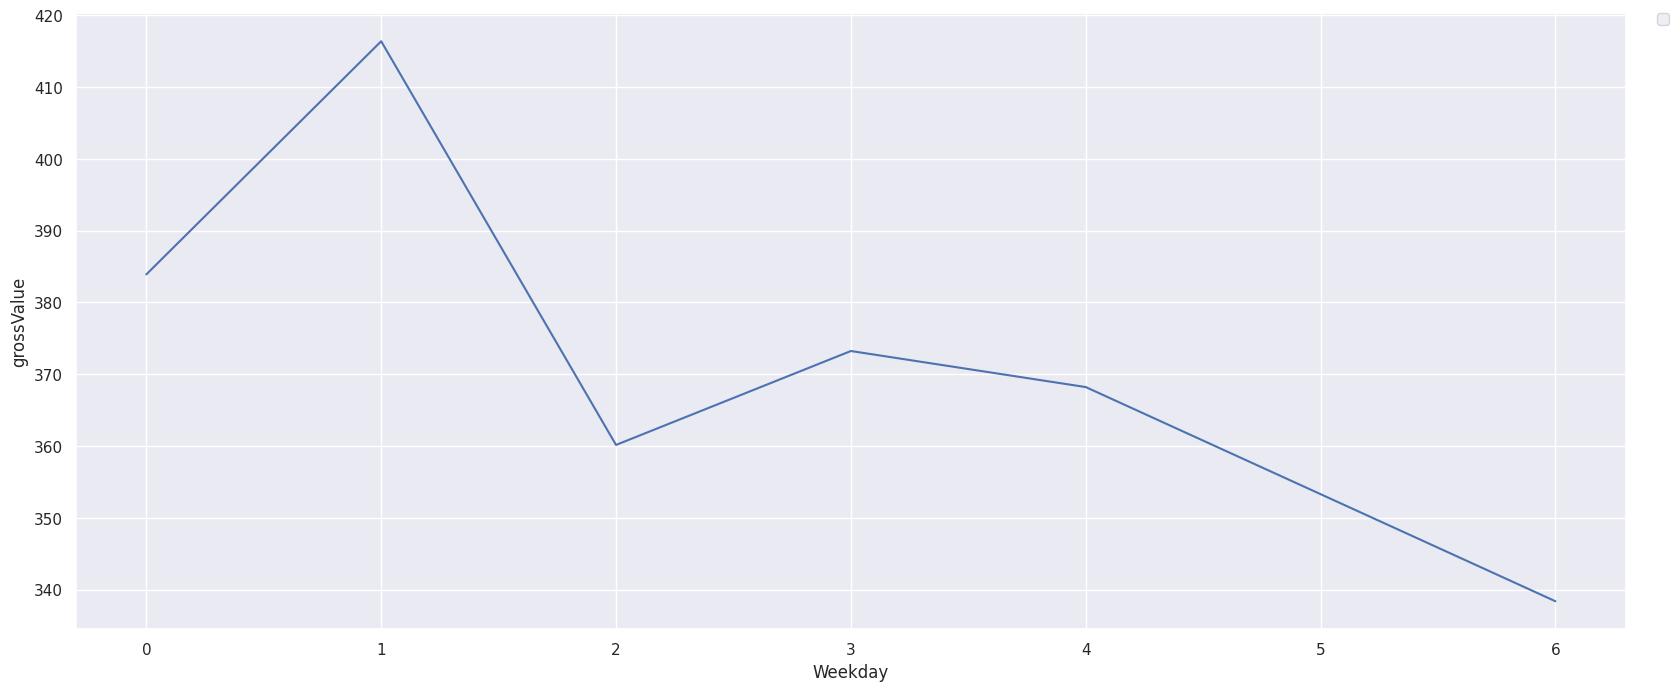

In [11]:
# Aggregating data accross weekdays
dayTrend = retail.groupby(['Weekday'])['grossValue'].agg('mean').reset_index().sort_values(by = 'grossValue',ascending = False)

sns.set(rc = {'figure.figsize':(20,8)})
sns.lineplot(data=dayTrend, x='Weekday', y='grossValue')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

We can also see that there is quite a bit of variability of buying patterns accross the days of the week. We will therefore take the week days also as another context 

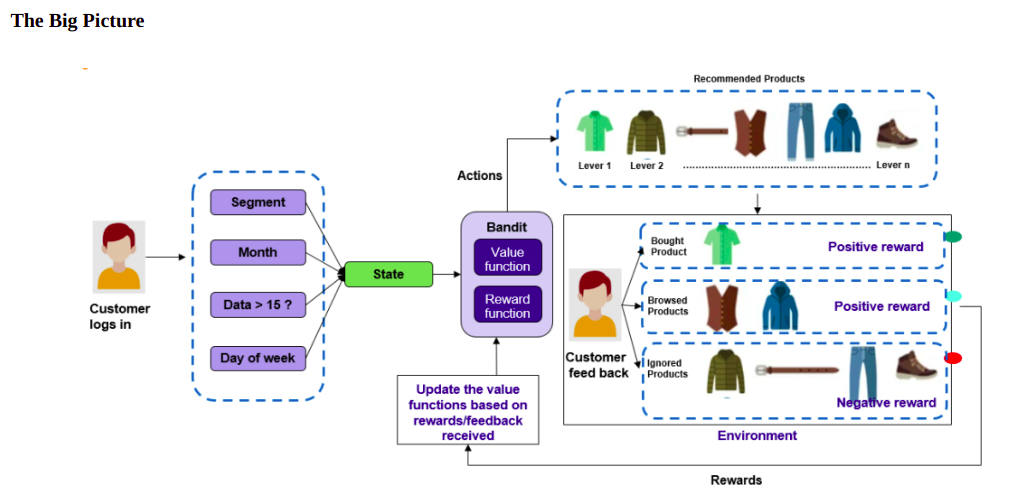